<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21_10kGNAD_simpletransformers_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying German News Articles with SimpleTransformers

## Objectives

1. Train a text classifier with transfer learning based on a pretrained German transformer model.
2. Keep the implementation simple (just a few lines of code) by using the SimpleTransformers library. It also has sensible default model settings.


## Approach

Use following pretrained models on the 10k German News Articles dataset to classify 9 news topics.

* `distilbert-base-german-cased`
* `deepset/gbert-base`
* `deepset/gelectra-large`

## Learnings

...

## Prerequisites

In [196]:
model_type = "distilbert"
model_name = "distilbert-base-german-cased"

# model_type = "bert"
# model_name = "deepset/gbert-base"

# model_type = "electra"
# model_name = "deepset/gelectra-base"

project_name = "10kgnad_default__" + model_name.replace("/", "_")

In [197]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Nov 16 20:05:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |   3443MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [198]:
# install transformers
!pip install -q -U tqdm transformers simpletransformers >/dev/null

# check installed version
!pip freeze | grep transformers
!pip freeze | grep torch
# simpletransformers==0.61.6 / 0.63.3
# transformers==4.6.1 / 4.12.3
# torch==1.8.1+cu101 / 1.10.0

simpletransformers==0.63.3
transformers==4.12.3
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl


In [199]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

from simpletransformers.classification import ClassificationModel
from transformers import AutoTokenizer
from transformers import logging
import wandb

# hide progress bar when downloading tokenizers - a workaround!
logging.get_verbosity = lambda : logging.NOTSET

# disable transformer warnings like "Some weights of the model checkpoint"
logging.set_verbosity_error()

# disable logging of wandb
os.environ["WANDB_SILENT"] = "true"

## Download Data

Using the [10k German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [200]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data

2.7M Nov 16 18:23 test.csv
 24M Nov 16 18:23 train.csv


## Import Data

In [201]:
data_dir = Path("data/")

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

def read_csv_10kGNAD(filepath: Path, columns=["labels", "text"]) -> pd.DataFrame:
    """Load 10kGNAD csv file, handling its specific file format."""
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=columns)
    return f

In [202]:
train_df = read_csv_10kGNAD(data_dir / 'train.csv')
print(train_df.shape[0], 'articles')
display(train_df.head())

9245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [203]:
test_df = read_csv_10kGNAD(data_dir / 'test.csv')
print(test_df.shape[0], 'articles')
display(test_df.head())

1028 articles


,labels,text
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


## Data Insights

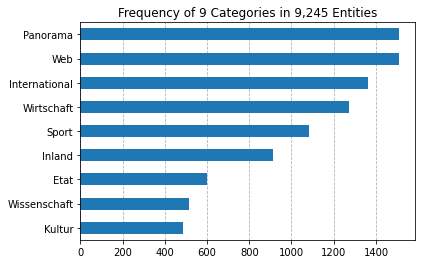

In [204]:
import matplotlib.pyplot as plt

def plot_categories(s: pd.Series):
    cat = s.value_counts(ascending=True)
    cat.plot.barh(title=f"Frequency of {len(cat)} Categories in {len(s):,} Entities", zorder=2)
    plt.gca().grid(axis='x', linestyle='--', zorder=1)

plot_categories(train_df.labels)

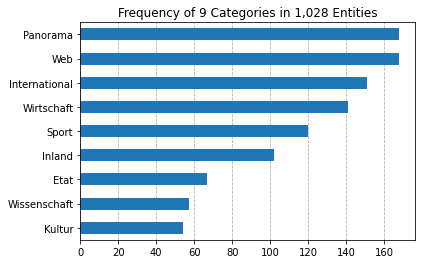

In [205]:
plot_categories(test_df.labels)

## Prepare Data for Model Training

There are a few requiremenf for feeding training data into SimpleTransformers:

* columns should be labeled `labels` and `text` (already done when reading the data)
* labels must be encoded as int values (starting at `0`!)

Additionally, we can handle imbalanced datasets by

* computing class weights for training

### Label Encoding

In [206]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(train: pd.DataFrame, test: pd.DataFrame):
    le = LabelEncoder()

    train_labels = le.fit_transform(train.labels)
    test_labels = le.transform(test.labels)

    return train.assign(labels=train_labels), test.assign(labels=test_labels), le

# caution overwriting data
train_df, test_df, le = encode_labels(train_df, test_df)
display(train_df.head())

,labels,text
0,5,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,3,"Erfundene Bilder zu Filmen, die als verloren g..."
2,6,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,7,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,1,Estland sieht den künftigen österreichischen P...


### Computing Class Weights

For this dataset the class weights have little effect.

In [207]:
from sklearn.utils.class_weight import compute_class_weight

def class_weights(labels: pd.Series) -> pd.DataFrame:
    """Compute class weights for imbalanced data."""
    uniq_labels = labels.unique()
    counts_s = labels.value_counts().reindex(uniq_labels)
    weights = compute_class_weight("balanced", classes=uniq_labels, y=labels)
    return pd.DataFrame({"count": counts_s, "weight": weights}).sort_index()

weights_df = class_weights(train_df.labels)
display(weights_df)

,count,weight
0,601,1.709188
1,913,1.125106
2,1360,0.755310
3,485,2.117984
4,1510,0.680280
5,1081,0.950252
6,1509,0.680730
7,1270,0.808836
8,516,1.990741


## Model Setup

In [208]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

def precision_multiclass(labels, preds):
    return precision_score(labels, preds, average='macro')

def recall_multiclass(labels, preds):
    return recall_score(labels, preds, average='macro')

In [209]:
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 300,    
    "evaluate_during_training_verbose": False,
    "evaluate_during_training_silent": True,
    "num_train_epochs": 2,
    "silent": False,  # turns all logging on or off (in train/eval)
    "fp16": False,
    "wandb_project": project_name,
    }

In [210]:
def train():

    # create a tokenizer first. Then we need to adjust SimpleTransformer's
    # ClassificationModel (train args) with the tokenizer's lower case setting.
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    args = {**train_args, **{ "do_lower_case": tokenizer.do_lower_case }}

    # Create the ClassificationModel
    model = ClassificationModel(model_type,
                                model_name,
                                num_labels=train_df.labels.nunique(),
                                weight=list(weights_df.weight),
                                args=args)


    steps, details = model.train_model(train_df,
                                       eval_df=test_df,
                                       verbose=False,  # no effect?
                                       show_running_loss=True,  # shows or hides running loss in progress bar
                                       f1=f1_multiclass,
                                       acc=accuracy_score,
                                       precision=precision_multiclass,
                                       recall=recall_multiclass)

    wandb.join()

    return model, details

In [211]:
%%time

# rerun this cell to train more models
model, details = train()

  0%|          | 0/9245 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1156 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

  0%|          | 0/1028 [00:00<?, ?it/s]

CPU times: user 3min 21s, sys: 12.3 s, total: 3min 33s
Wall time: 5min 59s


## Show Training Evaluation Metrics

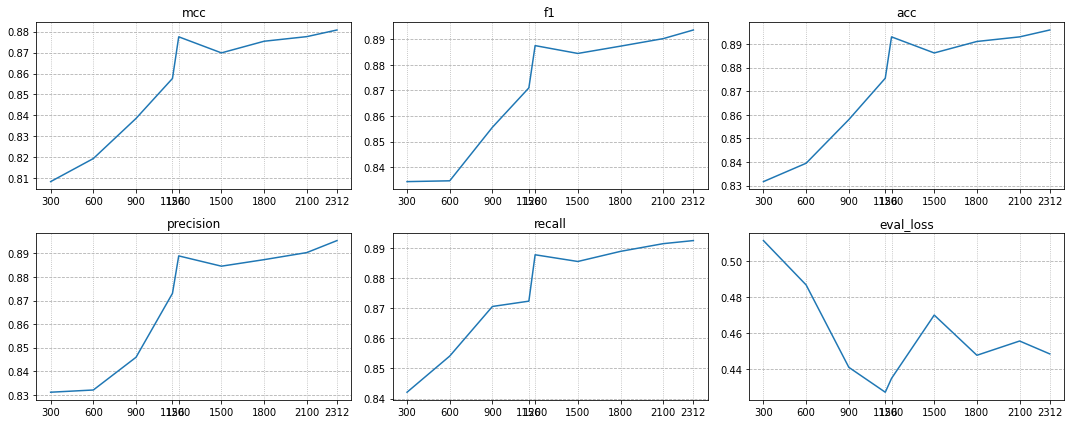

In [212]:
details.pop('list', None)
details_df = pd.DataFrame(details).set_index('global_step').drop('train_loss', axis=1)

fig, axs = plt.subplots(2, len(details_df.columns)//2, figsize=(15,6))

for col, ax in zip(details_df.columns, axs.flatten()):
    details_df[col].plot(ax=ax, zorder=2)
    ax.set_title(col)
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)
    ax.set_xlabel(None)
    ax.set_xticks(details_df.index)

plt.tight_layout()

---
## Evaluate Model

SimpleTransformers has a directory `best_model` but this contains only the best model from one training (updated when the model is evaluated during training).

From the [documentation](https://simpletransformers.ai/docs/usage/):

```
The directory where the best model (model checkpoints) will be saved (based on eval_during_training)
```

In [213]:
!ls -la outputs/

total 264176
drwxr-xr-x 25 root root      4096 Nov 16 19:47 .
drwxr-xr-x  1 root root      4096 Nov 16 18:26 ..
drwxr-xr-x  2 root root      4096 Nov 16 18:26 best_model
drwxr-xr-x  2 root root      4096 Nov 16 18:28 checkpoint-1000
drwxr-xr-x  2 root root      4096 Nov 16 18:29 checkpoint-1156-epoch-1
drwxr-xr-x  2 root root      4096 Nov 16 19:16 checkpoint-1200
drwxr-xr-x  2 root root      4096 Nov 16 19:17 checkpoint-1400
drwxr-xr-x  2 root root      4096 Nov 16 19:43 checkpoint-1500
drwxr-xr-x  2 root root      4096 Nov 16 19:17 checkpoint-1600
drwxr-xr-x  2 root root      4096 Nov 16 19:18 checkpoint-1800
drwxr-xr-x  2 root root      4096 Nov 16 18:26 checkpoint-200
drwxr-xr-x  2 root root      4096 Nov 16 19:18 checkpoint-2000
drwxr-xr-x  2 root root      4096 Nov 16 19:45 checkpoint-2100
drwxr-xr-x  2 root root      4096 Nov 16 19:19 checkpoint-2200
drwxr-xr-x  2 root root      4096 Nov 16 19:19 checkpoint-2312-epoch-2
drwxr-xr-x  2 root root      4096 Nov 16 19:34 checkpoint-2

In [214]:
# loading best model (as stored by SimpleTransformers during evaluation)
# model = ClassificationModel(model_type, "outputs/best_model")

In [215]:
result, model_outputs, wrong_predictions = model.eval_model(test_df,
                                                            f1=f1_multiclass,
                                                            acc=accuracy_score,
                                                            precision=precision_multiclass,
                                                            recall=recall_multiclass,
                                                            wandb_log=False
                                                            )

print(", ".join(f"{k}={v:.4}" for k,v in pd.Series(result).items()))
display(pd.Series(result))

  0%|          | 0/1028 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/129 [00:00<?, ?it/s]

mcc=0.8807, f1=0.8937, acc=0.8959, precision=0.8955, recall=0.8924, eval_loss=0.4483


mcc          0.880747
f1           0.893681
acc          0.895914
precision    0.895458
recall       0.892385
eval_loss    0.448291
dtype: float64

## Confusion Matrix and Classification Report

In [216]:
pred_s = pd.DataFrame(model_outputs).idxmax(axis=1)

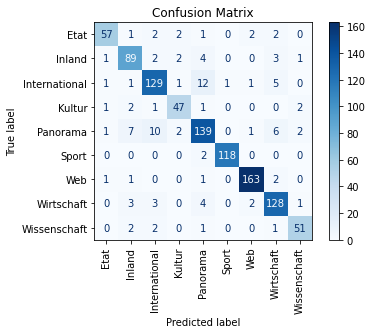

In [217]:
import sklearn.metrics as skm

test_labels = le.inverse_transform(test_df.labels)
pred_labels = le.inverse_transform(pred_s)

cm = skm.confusion_matrix(test_labels, pred_labels, labels=le.classes_)
cmd = skm.ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cmd.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix");

In [218]:
print(skm.classification_report(test_labels, pred_labels))

               precision    recall  f1-score   support

         Etat       0.92      0.85      0.88        67
       Inland       0.84      0.87      0.86       102
International       0.87      0.85      0.86       151
       Kultur       0.87      0.87      0.87        54
     Panorama       0.84      0.83      0.83       168
        Sport       0.99      0.98      0.99       120
          Web       0.96      0.97      0.97       168
   Wirtschaft       0.87      0.91      0.89       141
 Wissenschaft       0.89      0.89      0.89        57

     accuracy                           0.90      1028
    macro avg       0.90      0.89      0.89      1028
 weighted avg       0.90      0.90      0.90      1028



## Save Predictions

In [219]:
preds = pd.DataFrame(model_outputs, columns=le.classes_)
# preds.to_csv(data_dir / "predictions.csv", index=False)